# Tuning des modèles en enlevant Hillshade_9am

In [3]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
#X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
#X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

X_train_hill = X_train.drop(columns=['Hillshade_9am'])
X_test_hill = X_test.drop(columns=['Hillshade_9am'])

In [5]:
X_train_hill2 = X_train.drop(columns=['Hillshade_9am'])
X_test_hill2 = X_test.drop(columns=['Hillshade_9am'])

X_train_hill2['Elevation'] = X_train_hill2['Elevation'] - X_train_hill2['Vertical_Distance_To_Hydrology']
X_test_hill2['Elevation'] = X_test_hill2['Elevation'] - X_test_hill2['Vertical_Distance_To_Hydrology']

In [11]:
X_train_hill3 = X_train.drop(columns=['Hillshade_9am'])
X_test_hill3 = X_test.drop(columns=['Hillshade_9am'])

X_train_hill3['Aspect'] = np.sin(X_train_hill3['Aspect']*np.pi/180)
X_test_hill3['Aspect'] = np.sin(X_test_hill3['Aspect']*np.pi/180)

In [6]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

## Random Forest

In [24]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Fonction objectif pour Optuna
def objective(trial):
    # Définition de l'espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 10, 15, 20, None]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }

    # Initialisation du modèle avec les paramètres proposés
    model = RandomForestClassifier(**params)

    # Validation croisée pour évaluer la performance
    score = cross_val_score(model, X_train_hill, y_train, cv=7, scoring='accuracy').mean()

    # Retourne la métrique à maximiser
    return score

# Création de l'étude Optuna
study = optuna.create_study(direction="maximize", study_name="rf_optimization")

# Lancer l'optimisation
study.optimize(objective, n_trials=50, n_jobs=-1)  # Parallélisation avec n_jobs=-1

# Afficher les meilleurs paramètres
print("Meilleurs paramètres Random Forest :", study.best_params)
print("Meilleur score :", study.best_value)


[I 2024-12-20 23:03:51,569] A new study created in memory with name: rf_optimization
[I 2024-12-20 23:04:09,714] Trial 2 finished with value: 0.8248299319727891 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.8248299319727891.
[I 2024-12-20 23:04:12,817] Trial 5 finished with value: 0.858843537414966 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 5 with value: 0.858843537414966.
[I 2024-12-20 23:04:14,761] Trial 7 finished with value: 0.8584656084656085 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.858843537414966.
[I 2024-12-20 23:04:20,516] Trial 3 finished with value: 0.8380574452003025 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_s

Meilleurs paramètres Random Forest : {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Meilleur score : 0.871787603930461


In [14]:
from sklearn.ensemble import RandomForestClassifier
# Traduction des indices en valeurs concrètes
best_rf_params = {
    'max_depth': [5, 10, 15, 20, None][4],           
    'max_features': ['sqrt', 'log2'][0],             
    'min_samples_leaf': [1, 2, 4][0],                
    'min_samples_split': [2, 5, 10][0],              
    'n_estimators': [100, 200, 300, 400, 500][2]     
}

# Initialiser le modèle avec les valeurs concrètes
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train_hill3, y_train)

# Prédire sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test_hill3)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score, classification_report
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Précision Random Forest :", accuracy_rf)
print("Rapport de classification Random Forest :\n", classification_report(y_test, y_pred_rf))

Précision Random Forest : 0.8820546737213404
Rapport de classification Random Forest :
               precision    recall  f1-score   support

           1       0.80      0.78      0.79       648
           2       0.80      0.72      0.76       648
           3       0.86      0.90      0.88       648
           4       0.94      0.98      0.96       648
           5       0.92      0.96      0.94       648
           6       0.89      0.89      0.89       648
           7       0.93      0.95      0.94       648

    accuracy                           0.88      4536
   macro avg       0.88      0.88      0.88      4536
weighted avg       0.88      0.88      0.88      4536



## XGBoost

In [15]:
import xgboost as xgb

y_train_adj = y_train - 1
y_test_adj = y_test - 1

In [2]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Fonction objectif pour Optuna
def objective(trial):
    # Définition de l'espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 6, 9, 12]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': 42,
        'objective': 'multi:softmax',
        'num_class': 7  # Spécifique à la classification multiclasse
    }

    # Initialisation du modèle avec les paramètres proposés
    model = xgb.XGBClassifier(**params)

    # Validation croisée pour évaluer la performance
    score = cross_val_score(model, X_train_hill2, y_train_adj, cv=7, scoring='accuracy').mean()

    # Retourne la métrique à maximiser
    return score

# Création de l'étude Optuna
study = optuna.create_study(direction="maximize", study_name="xgb_optimization2")

# Lancer l'optimisation
study.optimize(objective, n_trials=50, n_jobs=-1)  # Parallélisation avec n_jobs=-1

# Afficher les meilleurs paramètres
print("Meilleurs paramètres XGBoost :", study.best_params)
print("Meilleur score :", study.best_value)


[I 2024-12-20 23:15:29,314] A new study created in memory with name: xgb_optimization2
[W 2024-12-20 23:15:29,326] Trial 1 failed with parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.20654776917501846, 'subsample': 0.5132823214378248, 'colsample_bytree': 0.673016845345267, 'gamma': 0.16524138755372242} because of the following error: NameError("name 'X_train_hill2' is not defined").
Traceback (most recent call last):
  File "/Users/steph/anaconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_96167/61559260.py", line 24, in objective
    score = cross_val_score(model, X_train_hill2, y_train_adj, cv=7, scoring='accuracy').mean()
                                   ^^^^^^^^^^^^^
NameError: name 'X_train_hill2' is not defined
[W 2024-12-20 23:15:29,343] Trial 1 failed with value None.
[W 2024-12-20 23:

NameError: name 'X_train_hill2' is not defined

In [17]:
import xgboost as xgb

# On utilise les meilleurs hyperparamètres trouvés par Hyperopt
best_xgb_params = {
    'colsample_bytree': 0.9935889419671114,
    'gamma': 0.012860005064671678,
    'learning_rate': 0.11209385123371478,
    'max_depth': 9,
    'n_estimators': [100, 200, 300, 400, 500][1],  
    'subsample': 0.7078887451962781
}

# Initialiser le modèle XGBoost avec les paramètres optimaux
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=7, **best_xgb_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
xgb_model.fit(X_train_hill3, y_train_adj)

# Prédire les classes sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test_hill3)

# Évaluer les performances du modèle
accuracy_xgb = accuracy_score(y_test_adj, y_pred_xgb)
print("Précision du modèle XGBoost :", accuracy_xgb)
print("Rapport de classification XGBoost :\n", classification_report(y_test_adj, y_pred_xgb))

Précision du modèle XGBoost : 0.8888888888888888
Rapport de classification XGBoost :
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       648
           1       0.80      0.73      0.76       648
           2       0.88      0.91      0.89       648
           3       0.96      0.98      0.97       648
           4       0.92      0.96      0.94       648
           5       0.91      0.91      0.91       648
           6       0.94      0.95      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



## LightGBM

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Fonction objectif pour Optuna
def objective(trial):
    # Définition de l'espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 10, 15, 20, -1]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 50, 70, 100]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'objective': 'multiclass',
        'verbosity': -1  # Supprime les messages de log de LightGBM
    }

    # Initialisation du modèle avec les paramètres proposés
    model = lgb.LGBMClassifier(**params)

    # Validation croisée pour évaluer la performance
    score = cross_val_score(model, X_train_hill2, y_train, cv=7, scoring='accuracy').mean()

    # Retourne la métrique à maximiser
    return score

# Création de l'étude Optuna
study = optuna.create_study(direction="maximize", study_name="lgb_optimization")

# Lancer l'optimisation
study.optimize(objective, n_trials=50, n_jobs=-1)  # Parallélisation avec n_jobs=-1

# Afficher les meilleurs paramètres
print("Meilleurs paramètres LightGBM :", study.best_params)
print("Meilleur score :", study.best_value)


[I 2024-12-20 23:16:21,500] A new study created in memory with name: lgb_optimization
[I 2024-12-20 23:21:30,664] Trial 2 finished with value: 0.8907785336356765 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.24559645674731306, 'num_leaves': 31, 'subsample': 0.9573133393529993, 'colsample_bytree': 0.8565173096284104}. Best is trial 2 with value: 0.8907785336356765.
[I 2024-12-20 23:22:06,935] Trial 1 finished with value: 0.8910619803476946 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.18788804528389721, 'num_leaves': 70, 'subsample': 0.7987727764782346, 'colsample_bytree': 0.9422548819119335}. Best is trial 1 with value: 0.8910619803476946.
[I 2024-12-20 23:24:06,773] Trial 6 finished with value: 0.891628873771731 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.25916017195227764, 'num_leaves': 31, 'subsample': 0.6343390297688909, 'colsample_bytree': 0.9844643456145725}. Best is trial 6 with value: 0.891628

KeyboardInterrupt: 

In [19]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Meilleurs paramètres de LightGBM (après avoir traduit les indices en valeurs)
best_lgb_params = {
    'colsample_bytree': 0.6284626649933062,
    'learning_rate': 0.08427513495693706,
    'max_depth': 15,
    'n_estimators': [100, 200, 300, 400, 500][1],  
    'num_leaves': [31, 50, 70, 100][3],             
    'subsample': 0.6894988308344379,
    'verbosity': -1  # Désactive les avertissements pendant l'entraînement
}

# Initialiser le modèle LightGBM avec les paramètres optimisés
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=7, **best_lgb_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
lgb_model.fit(X_train_hill2, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_lgb = lgb_model.predict(X_test_hill2)

# Évaluer les performances du modèle
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Précision du modèle LightGBM :", accuracy_lgb)
print("Rapport de classification LightGBM :\n", classification_report(y_test, y_pred_lgb))

Précision du modèle LightGBM : 0.8972663139329806
Rapport de classification LightGBM :
               precision    recall  f1-score   support

           1       0.82      0.80      0.81       648
           2       0.80      0.75      0.77       648
           3       0.89      0.92      0.90       648
           4       0.97      0.98      0.98       648
           5       0.93      0.95      0.94       648
           6       0.91      0.92      0.92       648
           7       0.95      0.96      0.95       648

    accuracy                           0.90      4536
   macro avg       0.90      0.90      0.90      4536
weighted avg       0.90      0.90      0.90      4536



## Extra Trees

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

# Fonction objectif pour Optuna
def objective(trial):
    # Définition de l'espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42  # Fixer la reproductibilité
    }

    # Initialisation du modèle avec les paramètres proposés
    model = ExtraTreesClassifier(**params)

    # Validation croisée pour évaluer la performance
    score = cross_val_score(model, X_train_hill, y_train, cv=7, scoring='accuracy').mean()

    # Retourne la métrique à maximiser
    return score

# Création de l'étude Optuna
study = optuna.create_study(direction="maximize", study_name="et_optimization")

# Lancer l'optimisation
study.optimize(objective, n_trials=50, n_jobs=-1)  # Parallélisation avec n_jobs=-1

# Afficher les meilleurs paramètres
print("Meilleurs paramètres ExtraTreesClassifier :", study.best_params)
print("Meilleur score :", study.best_value)


100%|██████████| 50/50 [15:32<00:00, 18.65s/trial, best loss: -0.881708238851096] 
Meilleurs paramètres ExtraTreesClassifier : {'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 2}


In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report
# Meilleurs paramètres de ExtraTreesClassifier
best_et_params = {
    'n_estimators': [100, 200, 300, 400, 500][2],  
    'max_depth': [None, 10, 20, 30, 40][0],           
    'min_samples_split': [2, 5, 10][0],       
    'min_samples_leaf': [1, 2, 4][0],          
    'max_features': ['sqrt', 'log2', None][2]
}

# Initialiser le modèle LightGBM avec les paramètres optimisés
et_model = ExtraTreesClassifier(**best_et_params, random_state=42, n_jobs=-1)

# Entraîner le modèle sur l'ensemble d'entraînement
et_model.fit(X_train_hill3, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_et = et_model.predict(X_test_hill3)

# Évaluer les performances du modèle
accuracy_et = accuracy_score(y_test, y_pred_et)
print("Précision du modèle ExtraTrees :", accuracy_et)
print("Rapport de classification ExtraTrees :\n", classification_report(y_test, y_pred_et))

Précision du modèle ExtraTrees : 0.8833774250440917
Rapport de classification ExtraTrees :
               precision    recall  f1-score   support

           1       0.78      0.78      0.78       648
           2       0.81      0.72      0.76       648
           3       0.88      0.90      0.89       648
           4       0.96      0.98      0.97       648
           5       0.92      0.96      0.94       648
           6       0.89      0.90      0.90       648
           7       0.93      0.94      0.94       648

    accuracy                           0.88      4536
   macro avg       0.88      0.88      0.88      4536
weighted avg       0.88      0.88      0.88      4536



## Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Définir l'espace de recherche pour GradientBoostingClassifier
space_gb = {
    'n_estimators': hp.choice('n_estimators', [ 100, 200, 300, 400]),     # Nombre d'arbres
    'max_depth': hp.choice('max_depth', [5, 7, 10, 12]),                  # Profondeur maximale
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),              # Taux d'apprentissage
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),      # Nombre minimum d'échantillons pour diviser
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),         # Nombre minimum d'échantillons dans une feuille
    'subsample': hp.uniform('subsample', 0.5, 1.0)                        # Fraction des échantillons pour chaque arbre
}

# Fonction objectif pour Hyperopt
def objective_gb(params):
    # Initialiser GradientBoostingClassifier avec les paramètres proposés
    model = GradientBoostingClassifier(**params, random_state=42)
    # Utiliser une validation croisée pour calculer la précision moyenne
    score = cross_val_score(model, X_train_hill, y_train, cv=7, scoring='accuracy').mean()
    # Retourner la perte (score négatif) car Hyperopt minimise cette fonction
    return {'loss': -score, 'status': STATUS_OK}

# Lancer l'optimisation avec Hyperopt pour GradientBoostingClassifier
trials_gb = Trials()
best_params_gb = fmin(
    fn=objective_gb,               # Fonction objectif
    space=space_gb,                # Espace de recherche
    algo=tpe.suggest,              # Algorithme bayésien pour l'optimisation
    max_evals=50,                  # Nombre d'itérations de recherche
    trials=trials_gb,              # Historique des essais
    rstate=np.random.default_rng(42)  # Fixer un seed pour la reproductibilité
)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres GradientBoostingClassifier :", best_params_gb)

100%|██████████| 50/50 [9:10:03<00:00, 660.07s/trial, best loss: -0.8909674981103554]    
Meilleurs paramètres GradientBoostingClassifier : {'learning_rate': 0.11317932139355968, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 3, 'subsample': 0.8011279046777869}


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Meilleurs paramètres de GradientBoostingClassifier
best_gb_params = {
    'n_estimators': 300,  
    'max_depth': 16,#[5, 7, 10, 12][3],           
    'learning_rate': 0.11782851482424293,  
    'min_samples_split': 5,       
    'min_samples_leaf': 6,         
    'subsample': 0.7409699669018692  
}

# Initialiser le modèle GradientBoostingClassifier avec les paramètres optimisés
gb_model = GradientBoostingClassifier(**best_gb_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
gb_model.fit(X_train_hill3, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_gb = gb_model.predict(X_test_hill3)

# Évaluer les performances du modèle
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Précision du modèle GradientBoosting :", accuracy_gb)
print("Rapport de classification GradientBoosting :\n", classification_report(y_test, y_pred_gb))

Précision du modèle GradientBoosting : 0.8988095238095238
Rapport de classification GradientBoosting :
               precision    recall  f1-score   support

           1       0.81      0.82      0.81       648
           2       0.83      0.74      0.79       648
           3       0.89      0.92      0.91       648
           4       0.96      0.99      0.97       648
           5       0.93      0.96      0.95       648
           6       0.91      0.91      0.91       648
           7       0.95      0.96      0.95       648

    accuracy                           0.90      4536
   macro avg       0.90      0.90      0.90      4536
weighted avg       0.90      0.90      0.90      4536



In [5]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Fonction objectif pour Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [ 300, 400, 450, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [ 10, 12, 14, 16]),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [ 5, 10, 13]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [ 2, 4, 6]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42
    }

    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train_hill, y_train, cv=7, scoring='accuracy').mean()
    return score

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction="maximize", study_name="gb_optimization", storage="sqlite:///optuna_study.db", load_if_exists=True)
study.optimize(objective, n_trials=50, n_jobs=-1)  # Parallélisation avec n_jobs=-1

# Afficher les meilleurs paramètres
print("Best score:", study.best_value)
print("Meilleurs paramètres trouvés :", study.best_params)

[I 2024-12-07 12:00:46,821] Using an existing study with name 'gb_optimization' instead of creating a new one.
[I 2024-12-07 12:20:36,350] Trial 9 finished with value: 0.8881330309901739 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.0988326219059468, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.5700002735264409}. Best is trial 9 with value: 0.8881330309901739.
[I 2024-12-07 12:21:57,753] Trial 15 finished with value: 0.8897392290249434 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.13511644147178914, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7894424176815351}. Best is trial 15 with value: 0.8897392290249434.
[I 2024-12-07 12:22:35,429] Trial 11 finished with value: 0.888416477702192 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.1339486825543792, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.8689900170747198}. Best is trial 15 with value: 0.88973922902

Best score: 0.8921012849584279
Meilleurs paramètres trouvés : {'n_estimators': 300, 'max_depth': 16, 'learning_rate': 0.11782851482424293, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7409699669018692}


## Soumission

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Définir les modèles de base avec les meilleurs hyperparamètres
random_forest = RandomForestClassifier(
    n_estimators=300,  
    max_depth=None,      
    random_state=42,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=1,
)

xgboost = XGBClassifier(
    colsample_bytree=0.9935889419671114,
    gamma=0.012860005064671678,
    learning_rate=0.11209385123371478,
    max_depth=9,
    n_estimators=200,
    subsample=0.7078887451962781,
    objective='multi:softmax',
    num_class=7,
    random_state=42
)

lightgbm = LGBMClassifier(
    colsample_bytree=0.6284626649933062,
    learning_rate=0.08427513495693706,
    max_depth=15,
    n_estimators=200,
    num_leaves=100,
    subsample=0.6894988308344379,
    objective='multiclass',
    num_class=7,
    random_state=42,
    verbosity=-1
)

extra_trees = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    max_features=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.11782851482424293,
    max_depth=16,
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=6, 
    subsample=0.7409699669018692 
)

# Définir le méta-modèle (un modèle simple comme la régression logistique)
# meta_model = GradientBoostingClassifier(
#     n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42
# )
meta_model = XGBClassifier(
    n_estimators=160, #150 #200,
    max_depth= 2,  #3,#4
    learning_rate= 0.1,  #0.1,
    colsample_bytree=0.92,
    subsample=0.75,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
    # LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
    # RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    # LogisticRegression(max_iter=1000)

# Créer le StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', random_forest),
        ('xgb', xgboost),
        ('lgbm', lightgbm),
        ('et', extra_trees),
        ('gb', gradient_boosting)
    ],
    final_estimator=meta_model,
    cv=10  # Utiliser une validation croisée pour le stacking
)

In [13]:
# Entraîner le modèle de stacking
stacking_model.fit(X_train_hill, y_train_adj)

KeyboardInterrupt: 

In [ ]:
# Prédire sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_hill)

# Évaluer les performances du modèle de stacking
accuracy_stack = accuracy_score(y_test_adj, y_pred_stack)
print("Précision du modèle de stacking :", accuracy_stack)
print("Rapport de classification du modèle de stacking :\n", classification_report(y_test_adj, y_pred_stack))

Précision du modèle de stacking : 0.9014550264550265
Rapport de classification du modèle de stacking :
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       648
           1       0.80      0.80      0.80       648
           2       0.89      0.91      0.90       648
           3       0.97      0.97      0.97       648
           4       0.95      0.95      0.95       648
           5       0.91      0.93      0.92       648
           6       0.96      0.94      0.95       648

    accuracy                           0.90      4536
   macro avg       0.90      0.90      0.90      4536
weighted avg       0.90      0.90      0.90      4536



In [5]:
y_adj = y - 1

X_test_full = pd.read_csv('test-full.csv')

In [6]:
X = X.drop(columns=['Hillshade_9am'])
X_test_full = X_test_full.drop(columns=['Hillshade_9am'])

In [25]:
y_adj = y - 1

# On entraîne le modèle de stacking
stacking_model.fit(X, y_adj)

KeyboardInterrupt: 

In [ ]:
# On prédit sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_full)

y_pred_stack = y_pred_stack + 1

In [ ]:
# On crée un DataFrame avec les Id et les Cover_Type prédits
submission_df = pd.DataFrame({
    'Id': X_test_full['Id'],
    'Cover_Type': y_pred_stack
})

# On sauvegarde le DataFrame en fichier CSV
submission_df.to_csv('soumissions/submission_stacking_Hillshade_opt_CV_30.csv', index=False)

Importances des features : [0.00411526 0.0016523  0.00447423 0.00290005 0.0014544  0.00193868
 0.00650139 0.00444846 0.0021203  0.0022511  0.00554815 0.00298615
 0.00168784 0.0014743  0.03470586 0.01022837 0.01132541 0.07097169
 0.01958705 0.03317051 0.06391394 0.01199242 0.01762171 0.02340973
 0.02659935 0.09618363 0.00925685 0.00170916 0.08493127 0.07125837
 0.08015152 0.02383036 0.06971164 0.08853582 0.10735274]


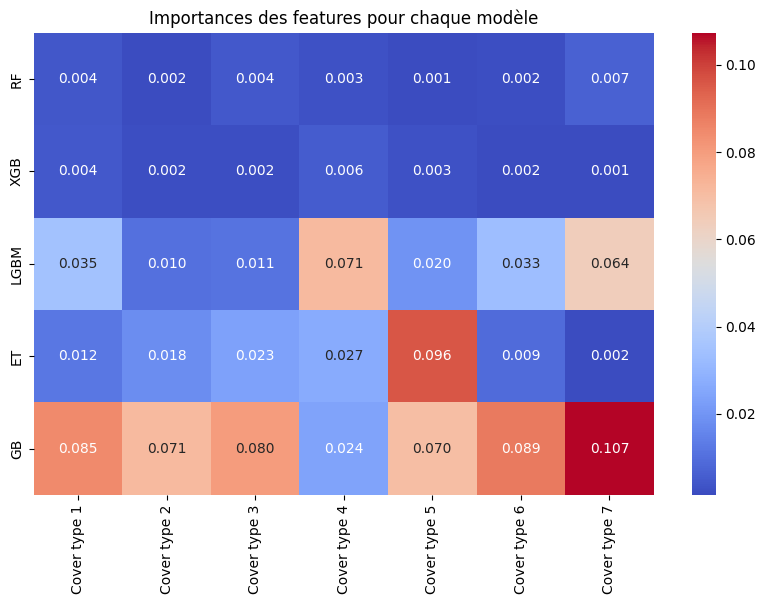

In [22]:
# Accéder au méta-modèle (XGBoost dans ce cas)
meta_model = stacking_model.final_estimator_

# Obtenir les importances des features
if hasattr(meta_model, 'feature_importances_'):
    importances = meta_model.feature_importances_
    print("Importances des features :", importances)

    importance_matrix = np.zeros((5,7))
    importance_matrix[0] = importances[:7]
    importance_matrix[1] = importances[7:14]
    importance_matrix[2] = importances[14:21]
    importance_matrix[3] = importances[21:28]
    importance_matrix[4] = importances[28:]

    # Visualisation des importances
    plt.figure(figsize=(10, 6))
    sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='coolwarm', xticklabels=['Cover type 1','Cover type 2','Cover type 3','Cover type 4','Cover type 5','Cover type 6','Cover type 7'], yticklabels=['RF', 'XGB', 'LGBM', 'ET', 'GB'])
    plt.title("Importances des features pour chaque modèle")
    plt.show()
    

else:
    print("Le méta-modèle ne fournit pas d'importances des features.")

In [8]:
stacking_model.fit(X_train_hill, y_train_adj)

/Users/steph/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(cv=10,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9935889419671114,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gam...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=2, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=160, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...))

In [45]:
meta_predictions = stacking_model.predict(X_test_hill)

erreur_total = (meta_predictions != y_test_adj)
print(f"Erreurs totales du modèle stacking: {erreur_total.sum()} sur {len(y_test_adj)} tests")

# Comparer les prédictions des sous-modèles avec celles du modèle empilé
for name, model in stacking_model.named_estimators_.items():
    y_sub_pred = model.predict(X_test_hill)
    errors_total = (y_sub_pred != y_test_adj)
    errors_corrected = (y_sub_pred != y_test_adj) & (meta_predictions == y_test_adj)
    errors_created = (y_sub_pred == y_test_adj) & (meta_predictions != y_test_adj)
    print(f"{name} :")
    print( f"erreurs totales du sous modèle: {errors_total.sum()} sur {len(y_test)} tests")
    print( f"erreurs corrigées: {errors_corrected.sum()} sur {len(y_test)} tests")
    print( f"erreurs créées: {errors_created.sum()} sur {len(y_test)} tests")

Erreurs totales du modèle stacking: 447 sur 4536 tests
rf :
erreurs totales du sous modèle: 523 sur 4536 tests
erreurs corrigées: 157 sur 4536 tests
erreurs créées: 81 sur 4536 tests
xgb :
erreurs totales du sous modèle: 514 sur 4536 tests
erreurs corrigées: 147 sur 4536 tests
erreurs créées: 80 sur 4536 tests
lgbm :
erreurs totales du sous modèle: 480 sur 4536 tests
erreurs corrigées: 108 sur 4536 tests
erreurs créées: 75 sur 4536 tests
et :
erreurs totales du sous modèle: 528 sur 4536 tests
erreurs corrigées: 155 sur 4536 tests
erreurs créées: 74 sur 4536 tests
gb :
erreurs totales du sous modèle: 484 sur 4536 tests
erreurs corrigées: 92 sur 4536 tests
erreurs créées: 55 sur 4536 tests


Calcul des SHAP values pour le sous-modèle : rf
Affichage des SHAP values pour rf...


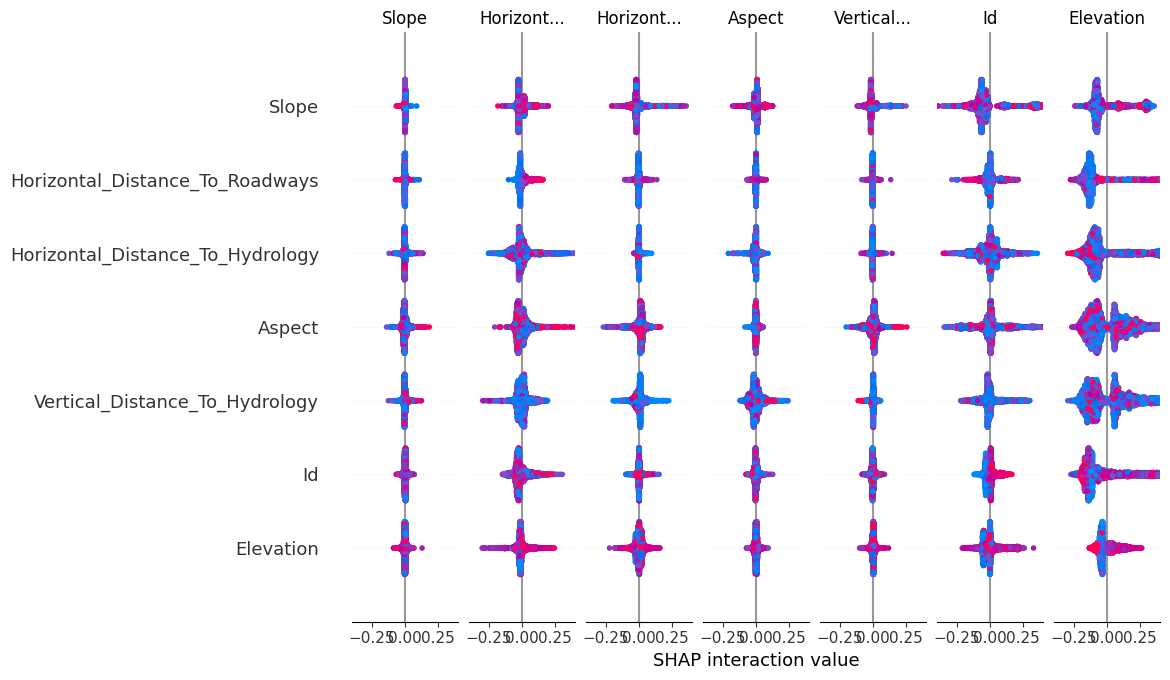

Calcul des SHAP values pour le sous-modèle : xgb
Affichage des SHAP values pour xgb...


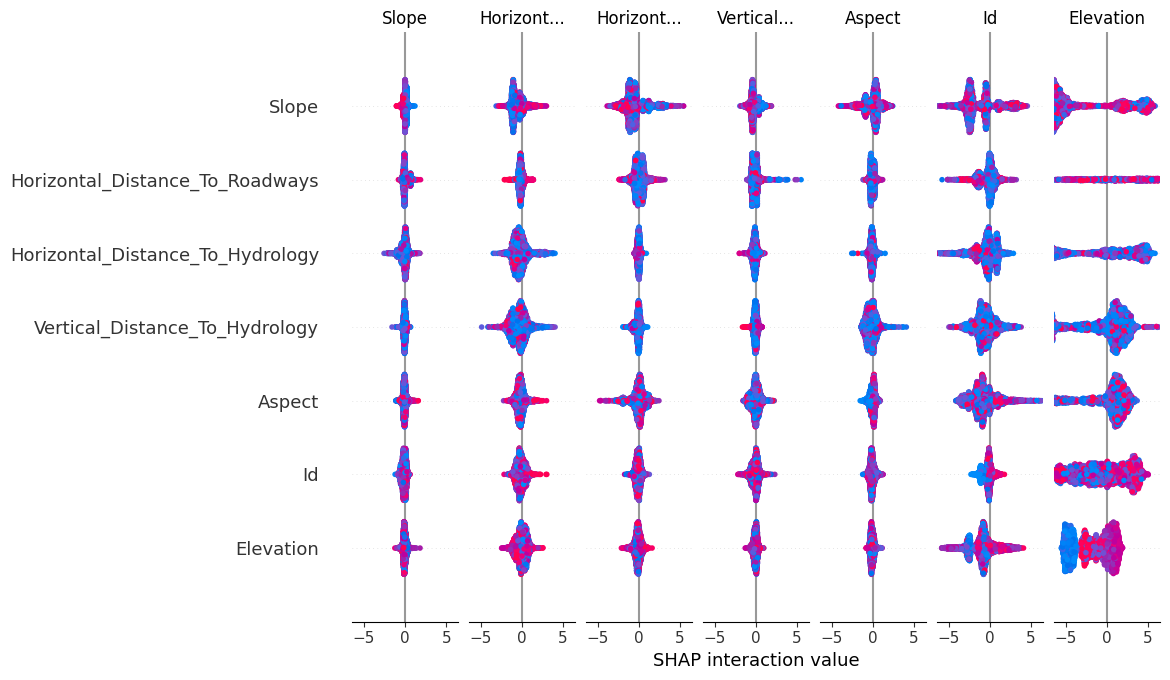

Calcul des SHAP values pour le sous-modèle : lgbm
Affichage des SHAP values pour lgbm...


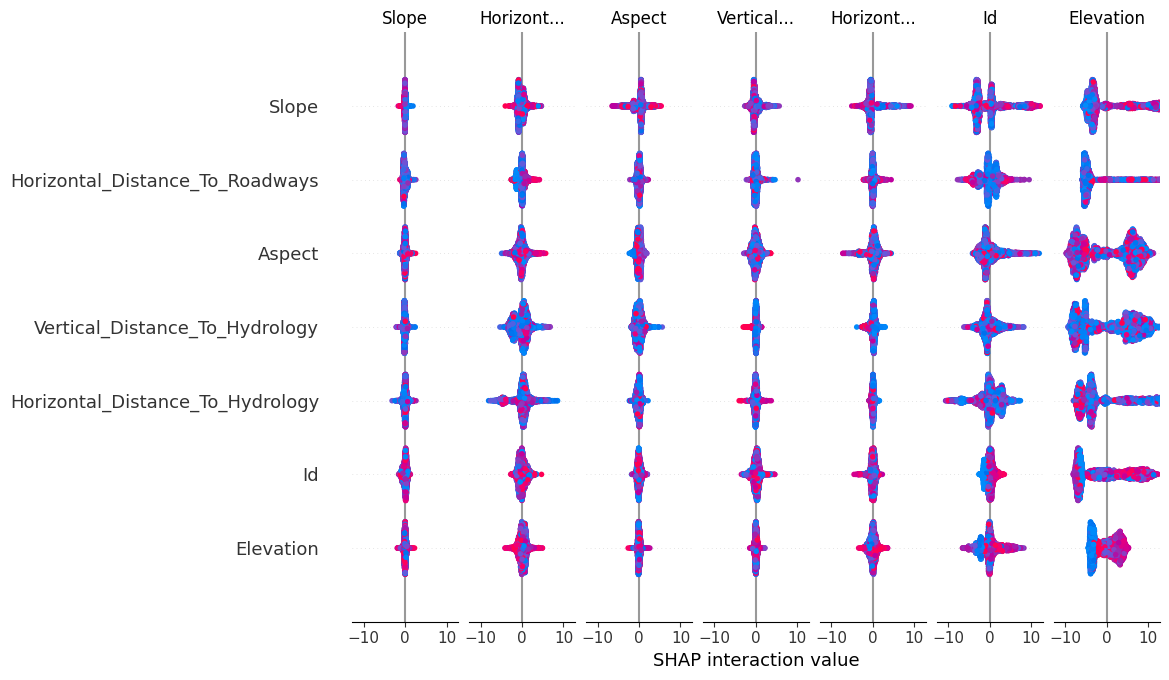

Calcul des SHAP values pour le sous-modèle : et
Affichage des SHAP values pour et...


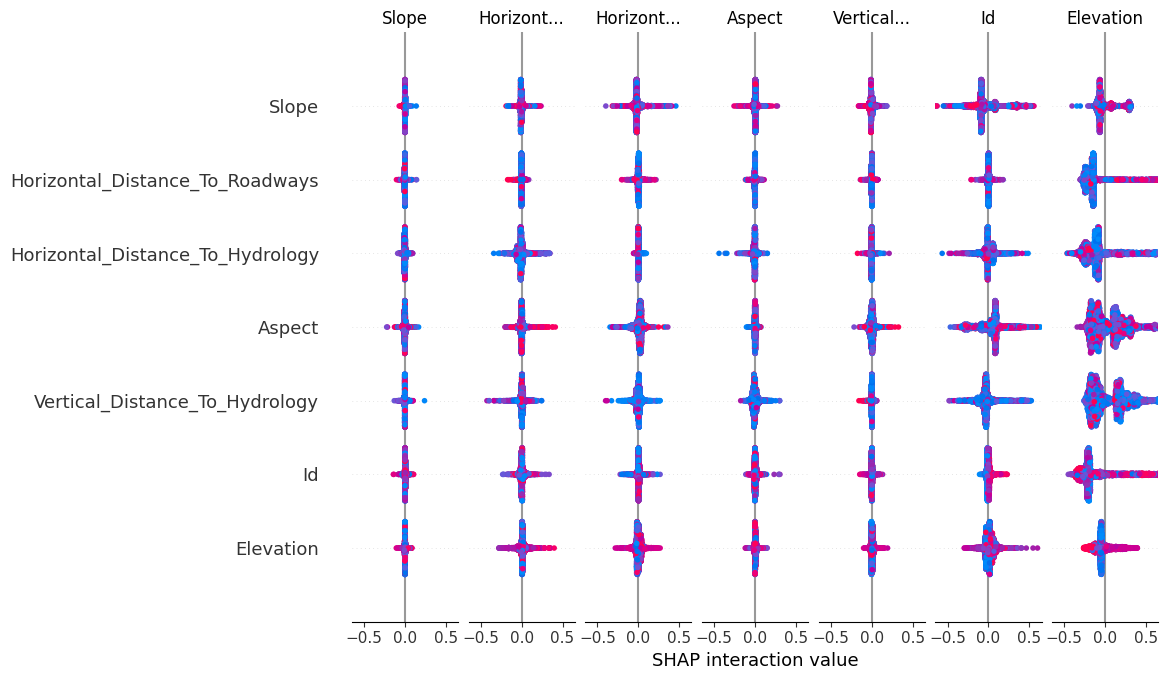

Calcul des SHAP values pour le sous-modèle : gb
Erreur lors du calcul des SHAP values pour le modèle gb: GradientBoostingClassifier is only supported for binary classification right now!


In [9]:
import shap
import matplotlib.pyplot as plt

# Boucle pour calculer et afficher les SHAP values pour chaque sous-modèle
for name, model in stacking_model.named_estimators_.items():
    print(f"Calcul des SHAP values pour le sous-modèle : {name}")
    
    try:
        # Initialisation de l'explainer pour les modèles basés sur des arbres
        if hasattr(model, "predict_proba"):  # Exemple : RandomForest, XGBoost, LightGBM
            explainer = shap.TreeExplainer(model)
        else:  # Modèles génériques (ou non basés sur des arbres)
            explainer = shap.KernelExplainer(model.predict, shap.sample(X_test_hill, 100))  # Sous-échantillonnage pour accélérer
        
        # Calcul des SHAP values
        shap_values = explainer.shap_values(X_test_hill)
        
        # Visualisation des valeurs SHAP
        print(f"Affichage des SHAP values pour {name}...")
        shap.summary_plot(shap_values, X_test_hill, plot_type="bar")
        plt.show()
    
    except Exception as e:
        print(f"Erreur lors du calcul des SHAP values pour le modèle {name}: {e}")